# Práctica Traductor - Álvaro Bartolomé Ucero

## Traductor español-inglés

### Import Required Libraries

In [5]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
# matplotlib inline
pd.set_option('display.max_colwidth', 200)

### Read Data

Our data is a text file of English-German sentence pairs. First we will read the file using the function defined below.

In [6]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

Now let's define a function to split the text into English-German pairs separated by '\n' and then split these pairs into English sentences and German sentences.

In [7]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

__Download the data from [here.](http://www.manythings.org/anki/deu-eng.zip)__ and extract "deu.txt" in your working directory.

In [8]:
data = read_text("data\spa.txt")
spa_eng = to_lines(data)
spa_eng = array(spa_eng)

The actual data contains over 150,000 sentence-pairs. However, we will use the first 50,000 sentence pairs only to reduce the training time of the model. You can change this number as per you system computation power.

In [9]:
spa_eng = spa_eng[:50000,:]

### Text Pre-Processing

#### Text Cleaning

Let's take a look at our data, then we will decide which pre-processing steps to adopt.

In [10]:
spa_eng

array([['Go.', 'Ve.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)'],
       ['Go.', 'Vete.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)'],
       ['Go.', 'Vaya.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)'],
       ...,
       ['Fatigue showed on her face.', 'Su cara mostraba fatiga.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #317786 (CM) & #1630578 (teskmon)'],
       ['Few students knew his name.',
        'Pocos estudiantes conocían su nombre.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #287661 (CK) & #1332261 (Shishir)'],
       ['Fill out the questionnaire.', 'Rellena el cuestionario.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #4305622 (CK) & #5869213 (albrusgher)']],
      dtype='<U278')

We will get rid of the punctuation marks, and then convert the text to lower case.

In [11]:
# Remove punctuation
spa_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_eng[:,0]]
spa_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_eng[:,1]]

In [12]:
spa_eng

array([['Go', 'Ve',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)'],
       ['Go', 'Vete',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)'],
       ['Go', 'Vaya',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)'],
       ...,
       ['Fatigue showed on her face', 'Su cara mostraba fatiga',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #317786 (CM) & #1630578 (teskmon)'],
       ['Few students knew his name',
        'Pocos estudiantes conocían su nombre',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #287661 (CK) & #1332261 (Shishir)'],
       ['Fill out the questionnaire', 'Rellena el cuestionario',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #4305622 (CK) & #5869213 (albrusgher)']],
      dtype='<U278')

In [13]:
# convert to lowercase
for i in range(len(spa_eng)):
    spa_eng[i,0] = spa_eng[i,0].lower()
    
    spa_eng[i,1] = spa_eng[i,1].lower()

In [14]:
spa_eng

array([['go', 've',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)'],
       ['go', 'vete',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)'],
       ['go', 'vaya',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)'],
       ...,
       ['fatigue showed on her face', 'su cara mostraba fatiga',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #317786 (CM) & #1630578 (teskmon)'],
       ['few students knew his name',
        'pocos estudiantes conocían su nombre',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #287661 (CK) & #1332261 (Shishir)'],
       ['fill out the questionnaire', 'rellena el cuestionario',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #4305622 (CK) & #5869213 (albrusgher)']],
      dtype='<U278')

#### Text to Sequence Conversion

To feed our data in a Seq2Seq model, we will have to convert both the input and the output sentences into integer sequences of fixed length. Before that, let's visualise the length of the sentences. We will capture the lengths of all the sentences in two separate lists for English and German, respectively.

In [15]:
# empty lists
eng_l = []
spa_l = []

# populate the lists with sentence lengths
for i in spa_eng[:,0]:
    eng_l.append(len(i.split()))

for i in spa_eng[:,1]:
    spa_l.append(len(i.split()))

In [16]:
length_df = pd.DataFrame({'eng':spa_l, 'spa':spa_l})
print(length_df)
print(max(length_df.eng))
print(max(length_df.spa))

       eng  spa
0        1    1
1        1    1
2        1    1
3        1    1
4        1    1
...    ...  ...
49995    4    4
49996    6    6
49997    4    4
49998    5    5
49999    3    3

[50000 rows x 2 columns]
12
12


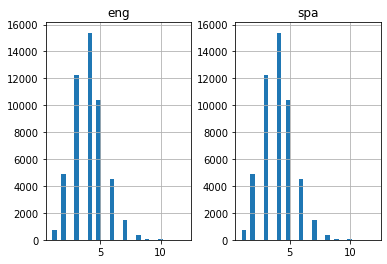

In [17]:
length_df.hist(bins = 30)
plt.show()

The maximum length of the German sentences is 11 and that of the English phrases is 8.

Let's vectorize our text data by using Keras's Tokenizer() class. It will turn our sentences into sequences of integers. Then we will pad those sequences with zeros to make all the sequences of same length.

In [18]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [19]:
# prepare english tokenizer
eng_tokenizer = tokenization(spa_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6917


In [20]:
# prepare Deutch tokenizer
spa_tokenizer = tokenization(spa_eng[:, 1])
spa_vocab_size = len(spa_tokenizer.word_index) + 1

spa_length = 8
print('Spanish Vocabulary Size: %d' % spa_vocab_size)

Spanish Vocabulary Size: 14176


In [21]:
print(spa_tokenizer.word_counts)

OrderedDict([('ve', 114), ('vete', 30), ('vaya', 39), ('váyase', 7), ('hola', 12), ('¡corre', 1), ('¡corran', 1), ('¡corra', 1), ('¡corred', 1), ('corred', 1), ('¿quién', 383), ('¡órale', 10), ('¡fuego', 4), ('¡incendio', 1), ('¡disparad', 3), ('¡ayuda', 2), ('¡socorro', 1), ('¡auxilio', 2), ('¡salta', 1), ('salte', 2), ('¡parad', 1), ('¡para', 4), ('¡pare', 1), ('¡espera', 4), ('esperen', 10), ('continúa', 14), ('continúe', 6), ('me', 3073), ('oculté', 1), ('escondí', 3), ('ocultaba', 1), ('escondía', 1), ('corrí', 13), ('corría', 4), ('lo', 2129), ('intento', 8), ('¡he', 2), ('ganado', 16), ('¡oh', 3), ('no', 5893), ('tomátelo', 2), ('con', 856), ('soda', 3), ('¡disparen', 1), ('¡dispara', 1), ('¡dispará', 1), ('¡dispare', 1), ('sonríe', 5), ('¡al', 2), ('ataque', 5), ('¡atacad', 1), ('¡ataque', 1), ('¡ataquen', 1), ('¡ataca', 1), ('levanta', 23), ('ahora', 505), ('mismo', 129), ('id', 7), ('vayan', 11), ('ya', 338), ('¡lo', 10), ('tengo', 883), ('¿lo', 63), ('pillas', 1), ('¿entendi

Given below is a function to prepare the sequences. It will also perform sequence padding to a maximum sentence length as mentioned above. 

In [22]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    print(seq)
    print(len(seq))
    return seq

<bound method Tokenizer.texts_to_sequences of <keras_preprocessing.text.Tokenizer object at 0x000001D5AD17AA08>>


### Model Building

We will now split the data into train and test set for model training and evaluation, respectively.

In [23]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(spa_eng, test_size=0.2, random_state = 12)

It's time to encode the sentences. We will encode German sentences as the input sequences and English sentences as the target sequences. It will be done for both train and test datasets.

In [24]:
# prepare training data
trainX = encode_sequences(spa_tokenizer, spa_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

[[   1    2  969 ...   33    0    0]
 [  11   13  728 ... 2951    0    0]
 [  30  486   14 ...  231    0    0]
 ...
 [  10 3406    7 ...    0    0    0]
 [4520   14   40 ... 1504    0    0]
 [  81  381  250 ...    0    0    0]]
40000
[[   3  487   67 ...    0    0    0]
 [   9  327   43 ...    0    0    0]
 [   1   17   70 ...   50    0    0]
 ...
 [   2  327   13 ...    0    0    0]
 [1224  123  755 ...   25    0    0]
 [   1   50    7 ...    0    0    0]]
40000


In [25]:
print(trainX.shape)
print(trainY.shape)

(40000, 8)
(40000, 8)


In [26]:
# prepare validation data
testX = encode_sequences(spa_tokenizer, spa_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

[[1053   84 1197 ...    0    0    0]
 [  22   78   29 ...    0    0    0]
 [  70   20  832 ...    0    0    0]
 ...
 [1267  141   25 ...    0    0    0]
 [  38  240    6 ...    0    0    0]
 [   3  295  157 ...    0    0    0]]
10000
[[ 81  51  34 ...   0   0   0]
 [  1 108  38 ...   0   0   0]
 [ 71 532   2 ...   0   0   0]
 ...
 [ 11   2  26 ...   0   0   0]
 [  2  17 629 ...   0   0   0]
 [  9   4 224 ...   0   0   0]]
10000


In [27]:
print(testX.shape)
print(testY.shape)

(10000, 8)
(10000, 8)


Now comes the exciting part! Let us define our Seq2Seq model architecture. We are using an Embedding layer and an LSTM layer as our encoder and another LSTM layer followed by a Dense layer as the decoder.  

In [28]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))    
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

Details about the RepeatVector :  https://campus.datacamp.com/courses/machine-translation-in-python/implementing-an-encoder-decoder-model-with-keras?ex=6

We are using RMSprop optimizer in this model as it is usually a good choice for recurrent neural networks.

In [29]:
print(spa_vocab_size)
print(eng_vocab_size)
print(spa_length)
print(eng_length)

14176
6917
8
8


In [30]:
model = build_model(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




Please note that we have used __'sparse_categorical_crossentropy'__ as the loss function because it allows us to use the target sequence as it is instead of one hot encoded format. One hot encoding the target sequences with such a huge vocabulary might consume our system's entire memory.

It seems we are all set to start training our model. We will train it for 30 epochs and with a batch size of 512. You may change and play these hyperparameters. We will also be using __ModelCheckpoint()__ to save the best model with lowest validation loss. I personally prefer this method over early stopping.

Solo he probado con el traductor español-inglés porque tardaba muchísimo en ejecutarse el modelo. Sin embargo el código sería el mismo para cualquier otro traductor, solo que cambiando el dataset "data\spa.txt" por cualquier otro.

In [31]:
filename = 'model.h1'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)




Train on 32000 samples, validate on 8000 samples
Epoch 1/30





32000/32000 [==============================] - 178s 6ms/step - loss: 3.9416 - val_loss: 3.3503

Epoch 00001: val_loss improved from inf to 3.35029, saving model to model.h1
Epoch 2/30
32000/32000 [==============================] - 173s 5ms/step - loss: 3.2444 - val_loss: 3.2516

Epoch 00002: val_loss improved from 3.35029 to 3.25164, saving model to model.h1
Epoch 3/30
32000/32000 [==============================] - 177s 6ms/step - loss: 3.0977 - val_loss: 3.0970

Epoch 00003: val_loss improved from 3.25164 to 3.09705, saving model to model.h1
Epoch 4/30
32000/32000 [==============================] - 178s 6ms/step - loss: 2.9552 - val_loss: 2.9993

Epoch 00004: val_loss improved from 3.09705 to 2.99931, saving model to model.h1
Epoch 5/30
32000/32000 [==============================] - 176s 5ms/step - loss: 2.8087 - val_loss: 2.8467

Epoch 00005: val_loss improved from 2.99931 to 2.84666, saving model to model.h1
Epoch 6

Let's compare the training loss and the validation loss.

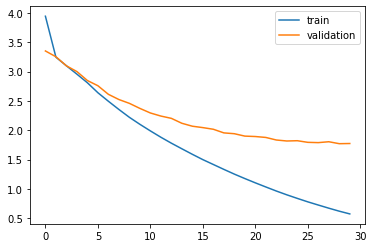

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

### Make Predictions

Let's load the saved model to make predictions.

In [34]:
model = load_model('model.h1')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [35]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [36]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [37]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [38]:
pd.set_option('display.max_colwidth', 200)

In [39]:
pred_df.head(15)

,actual,predicted
0,so how did this happen,what does he happen
1,i eat here,i talked here
2,who helped you,who helped you
3,smoke appeared,he made all right
4,they went to new zealand,they went from
5,can you explain it to me,can i explain it me
6,four times five is twenty,four plus is eight
7,i just wanted to see you,i wanted to see you
8,im a little crazy,im a little crazy
9,im sorry for what i did,i was sorry i


In [39]:
pred_df.tail(15)

,actual,predicted
9985,do you need a ride,can i sit you
9986,it is very small,its very small
9987,we can handle that,we can count it
9988,nobody believes you,no one believes you
9989,tom never changes,tom never laughs
9990,i just emailed you,i just found him tom
9991,tom is so stupid,tom is so stupid
9992,i found tom,i found tom
9993,i met mary yesterday,i saw her yesterday
9994,try and stop me,try to me


In [40]:
pred_df.tail(15)

,actual,predicted
9985,you really are nuts,youre really so wrong
9986,they kept running,they continued away
9987,all of these are mine,these are mine
9988,youve come too early,we have too early
9989,nobody can stop tom,nobody will knows
9990,i dont mind waiting,i wont regret it
9991,happy thanksgiving,many of please
9992,i loved her,i loved her
9993,did you come here alone,did he live here there
9994,were surrounded,were moving


In [41]:
pred_df.sample(15)

,actual,predicted
4491,our team can win,read team will want
6354,ill go in,ill going back
4064,be watchful,stop focused
3684,i never get tired of that,i never about you
7906,thats true isnt it,thats isnt it
9686,tom is afraid of the dark,tom is in at the
7011,i have a stomachache,my have hurts
7822,i didnt know it was tom,i didnt know tom was
7909,i ask your forgiveness,im your
8319,are those yours,are those
